In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
import os

## FUNCTIONS

In [3]:
# Step 1: Generate Triplegs
# Function to extract tripleg sequences
def get_tripleg_sequences(triplegs_file):
    triplegs = pd.read_csv(triplegs_file)
    
    sequences = []
    for _, row in triplegs.iterrows():
        # Extract coordinates from the LINESTRING column
        coordinates = extract_coordinates_from_linestring(row['geom'])
        sequences.append(coordinates)  # Each tripleg becomes a sequence of (x, y) pairs
    
    return sequences

# Helper function to parse LINESTRING column
def extract_coordinates_from_linestring(linestring):
    # Assuming LINESTRING format is: "LINESTRING (x1 y1, x2 y2, ...)"
    coordinates = linestring.replace("LINESTRING (", "").replace(")", "").split(", ")
    return [tuple(map(float, coord.split())) for coord in coordinates]

In [5]:
# Step 2: Prepare Sequences for LSTM
def prepare_sequences(triplegs_file, sequence_length=10):
    print(f"Preparing sequences from {triplegs_file}...")
    sequences = get_tripleg_sequences(triplegs_file)  # Extract sequences from triplegs
    input_sequences = []
    targets = []

    for seq in sequences:
        for i in range(len(seq) - sequence_length):
            input_sequences.append(seq[i:i + sequence_length])  # Input sequence
            targets.append(seq[i + sequence_length])  # Next location target

    input_sequences = np.array(input_sequences)
    targets = np.array(targets)
    print(f"Prepared {len(input_sequences)} sequences.")
    return input_sequences, targets

In [7]:
# Step 3: Define LSTM Model
from tensorflow.keras.layers import Input

def build_lstm_model(sequence_length):
    model = Sequential([
        Input(shape=(sequence_length, 2)),  # Explicitly define the input shape
        LSTM(64, return_sequences=False),  # LSTM layer
        Dense(2)  # Output layer for x, y predictions
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    print("LSTM model built.")
    return model


In [9]:
# Step 4: Train, Save/Load the Model
def train_model(model, train_seq, train_targets, epochs=20, batch_size=64):
    print("Training the model...")
    model.fit(train_seq, train_targets, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1)
    print("Model training complete.")
    return model

# Function to save the model locally
def save_model_locally(model, filename):
    model.save(f'{city_key}_model.keras')
    print(f"Model saved to {city_key}_model.keras")

# Function to load the model if it exists
def load_model_locally(city_key):
    filepath = f"{city_key}_model.keras"
    if os.path.exists(filepath):
        print(f"Loading model from {filepath}...")
        return load_model(filepath)
    else:
        print(f"No existing model found at {filepath}. Train a new model.")
        return None

In [11]:
# Step 5: Evaluate the Model
def evaluate_model(model, test_seq, test_targets):
    print("Evaluating the model...")
    test_loss = model.evaluate(test_seq, test_targets, verbose=1)
    print(f"Test Loss (MSE): {test_loss}")
    rmse = np.sqrt(test_loss)
    print(f"RMSE: {rmse}")
    return test_loss

In [13]:
# Step 6: Predict Next Locations
def predict_next_locations(model, test_seq, test_targets):
    predictions = model.predict(test_seq)
    print("Example predictions:")
    for i in range(5):  # Show the first 5 predictions
        print(f"True: {test_targets[i]}, Predicted: {predictions[i]}")
    return predictions

__

## MAIN DRIVER

In [81]:
city_key = "cityC"  # Choose between 'cityA', 'cityB', 'cityC', 'cityD' 
sequence_length = 10 # Define the sequence length for LSTM

In [19]:
# Step 1: Preprocess Data and Generate Triplegs
# preprocess_and_generate_triplegs(city_key)
# Get triplegs file
# This is done in another Task

### LSTM

In [83]:
# Step 2: Prepare Sequences
triplegs_file = f"triplegs_{city_key}.csv"

In [85]:
print(f"Step 2: Preparing sequences from triplegs for {city_key}...")
input_sequences, targets = prepare_sequences(triplegs_file, sequence_length)

Step 2: Preparing sequences from triplegs for cityC...
Preparing sequences from triplegs_cityC.csv...
Prepared 413818 sequences.


In [87]:
# Split into training and testing sets
train_size = int(0.8 * len(input_sequences))
train_seq, test_seq = input_sequences[:train_size], input_sequences[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]

In [89]:
# Attempt to load the saved model
model_city = load_model_locally(city_key)

# Recompile the model to rebuild metrics
if model_city != None:
    model_city.compile(optimizer='adam', loss='mean_squared_error')
    print(f"Loaded and recompiled model from {city_key}_model.keras")

# model_city = None # Uncomment this line and run to train forcefully

No existing model found at cityC_model.keras. Train a new model.


In [331]:
# print(model_city)

<Sequential name=sequential_2, built=True>


In [ ]:
# Step 3: Build, Train, Save LSTM Model
if model_city is None:  # Train only if no saved model exists
    # Build and train the model
    model_city = build_lstm_model(sequence_length)  # Adjust sequence_length as needed
    model_city = train_model(model_city, train_seq, train_targets, epochs=20, batch_size=64)

    # Save the trained model locally
    save_model_locally(model_city, f'{city_key}_model')

print(f"Model for {city_key} is ready.\n")

LSTM model built.
Training the model...
Epoch 1/20
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 6023.3032 - val_loss: 183.9945
Epoch 2/20
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 145.6611 - val_loss: 66.9150
Epoch 3/20
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 74.5287 - val_loss: 60.0175
Epoch 4/20
2173/4139 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 65.4918

In [67]:
# Step 4: Evaluate the Model
print(f"Step 5: Evaluating the model for {city_key}...")
evaluate_model(model_city, test_seq, test_targets)

Step 5: Evaluating the model for cityB...
Evaluating the model...
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 2s 543us/step - loss: 66.1122
Test Loss (MSE): 71.36393737792969
RMSE: 8.44771787987322


71.36393737792969

In [71]:
# Step 5: Predict Next Locations
print(f"Step 6: Predicting next locations for {city_key}...")
predictions = predict_next_locations(model_city, test_seq, test_targets)

Step 6: Predicting next locations for cityB...
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 2s 532us/step
Example predictions:
True: [92. 77.], Predicted: [94.288086 81.084404]
True: [96. 78.], Predicted: [92.730255 79.030304]
True: [74. 78.], Predicted: [71.69825 80.30676]
True: [73. 79.], Predicted: [71.60328  78.713036]
True: [87. 80.], Predicted: [73.524315 81.155945]


### Graphs

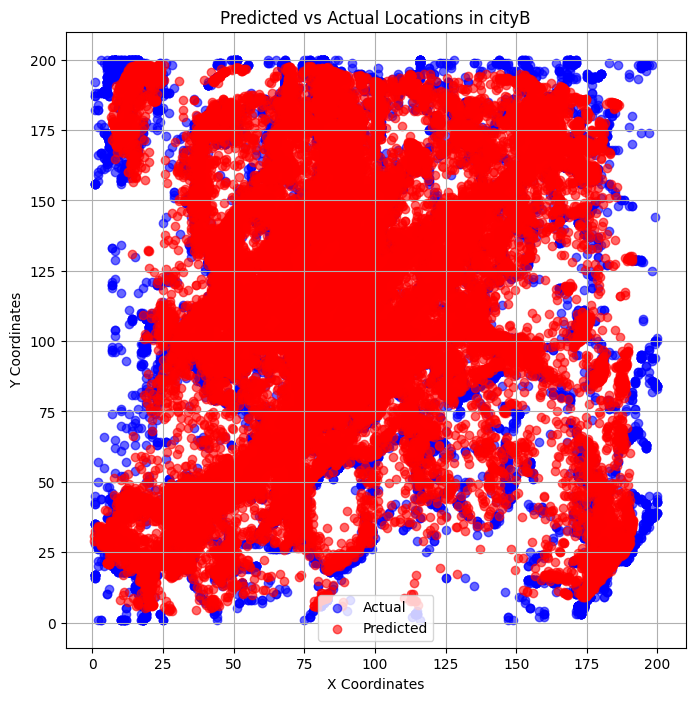

In [73]:
import matplotlib.pyplot as plt

# Extract true and predicted values for x and y
true_x, true_y = test_targets[:, 0], test_targets[:, 1]
pred_x, pred_y = predictions[:, 0], predictions[:, 1]

plt.figure(figsize=(8, 8))
plt.scatter(true_x, true_y, color='blue', label='Actual', alpha=0.6)
plt.scatter(pred_x, pred_y, color='red', label='Predicted', alpha=0.6)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title(f'Predicted vs Actual Locations in {city_key}')
plt.legend()
plt.grid()
plt.show()


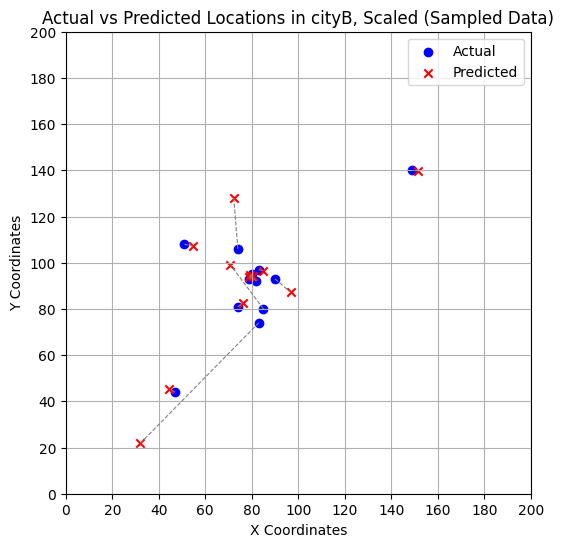

In [75]:
# Select a random subset of test samples to visualize
sample_idx = np.random.choice(len(test_targets), size=12, replace=False)

plt.figure(figsize=(6, 6))
plt.scatter(test_targets[sample_idx, 0], test_targets[sample_idx, 1], label="Actual", marker='o', color='blue')
plt.scatter(predictions[sample_idx, 0], predictions[sample_idx, 1], label="Predicted", marker='x', color='red')

# Draw lines connecting corresponding points
for i in sample_idx:
    plt.plot([test_targets[i, 0], predictions[i, 0]], 
             [test_targets[i, 1], predictions[i, 1]], 
             color='gray', linestyle='--', linewidth=0.8)

# Set labels and title
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title(f'Actual vs Predicted Locations in {city_key}, Scaled (Sampled Data)')

# Set x and y axis limits and ticks
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.xticks(np.arange(0, 201, 20))  # Tick marks from 0 to 200 with increments of 20
plt.yticks(np.arange(0, 201, 20))  # Tick marks from 0 to 200 with increments of 20

# Add grid, legend, and show the plot
plt.legend()
plt.grid()
plt.show()


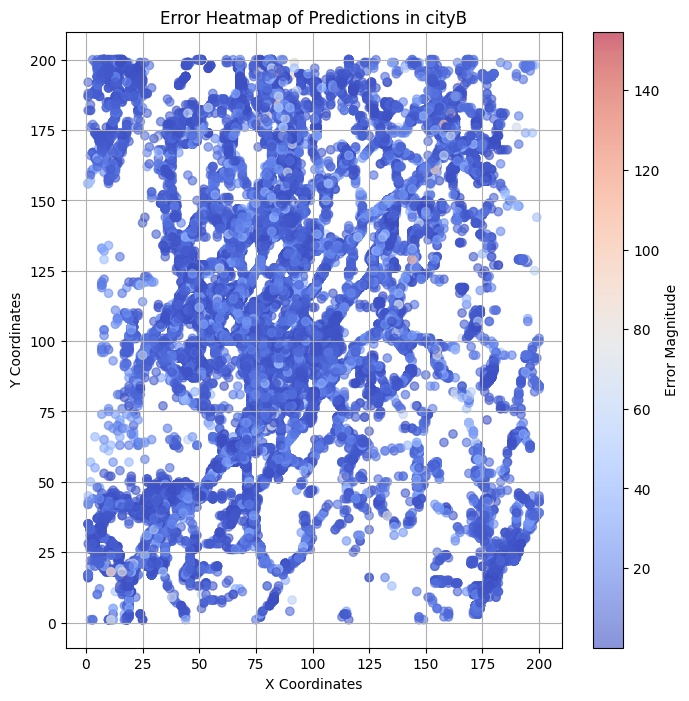

In [77]:
# Compute the error magnitude
errors = np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2)

# Create a scatter plot with error magnitudes
plt.figure(figsize=(8, 8))
plt.scatter(true_x, true_y, c=errors, cmap='coolwarm', label='Error Magnitude', alpha=0.6)
plt.colorbar(label='Error Magnitude')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title(f'Error Heatmap of Predictions in {city_key}')
plt.grid()
plt.show()


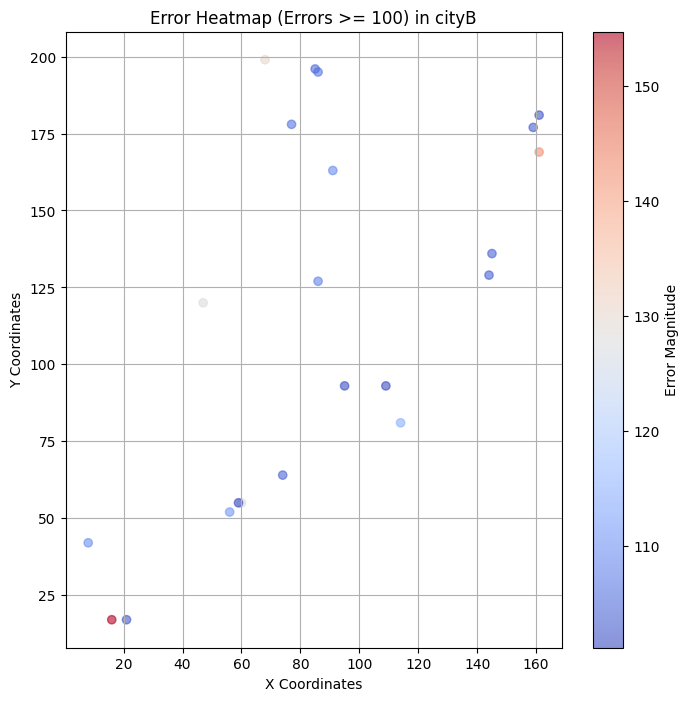

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the error magnitude
errors = np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2)

# Define the threshold
error_threshold = 100

# Mask errors below the threshold
filtered_true_x = true_x[errors >= error_threshold]
filtered_true_y = true_y[errors >= error_threshold]
filtered_errors = errors[errors >= error_threshold]

# Create a scatter plot with error magnitudes
plt.figure(figsize=(8, 8))
scatter = plt.scatter(filtered_true_x, filtered_true_y, c=filtered_errors, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Error Magnitude')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title(f'Error Heatmap (Errors >= {error_threshold}) in {city_key}')
plt.grid()
plt.show()


_

## Hyperparameter Tuning

In [49]:
import scipy.stats as stats
seq_dict = {}

In [51]:
city_key = "cityA"  # Choose between 'cityA', 'cityB', 'cityC', 'cityD' 
triplegs_file = f"triplegs_{city_key}.csv"
sequences = get_tripleg_sequences(triplegs_file)

In [233]:
seq_dict[city_key] = sequences

In [235]:
seq_dict.keys()

dict_keys(['cityA', 'cityB', 'cityC', 'cityD'])

### Changing Sequence Length

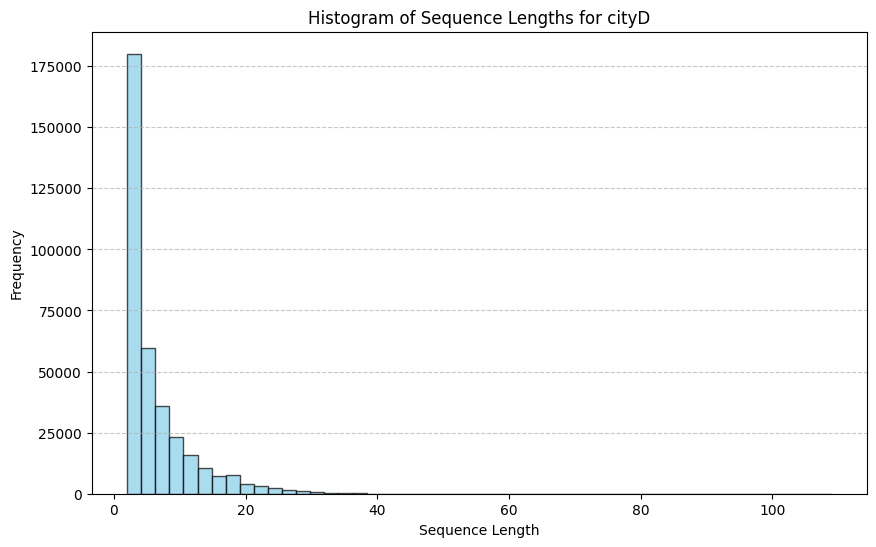

In [349]:
city_key = "cityD"  # Choose between 'cityA', 'cityB', 'cityC', 'cityD' 
sequences = seq_dict[city_key]
sequence_lengths = [len(seq) for seq in sequences]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"Histogram of Sequence Lengths for {city_key}")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [309]:
seq_len = 5
print(f"\nTesting with sequence length: {seq_len}")

# Step 1: Prepare sequences
input_sequences = []
targets = []

for seq in sequences:
    for i in range(len(seq) - seq_len):
        input_sequences.append(seq[i:i + seq_len])  # Input sequence
        targets.append(seq[i + seq_len])  # Next location target

input_sequences = np.array(input_sequences)
targets = np.array(targets)
print(f"Prepared {len(input_sequences)} sequences.")


Testing with sequence length: 5
Prepared 849583 sequences.


In [311]:
# Step 2: Train-test split
train_size = int(0.8 * len(input_sequences))
train_seq, test_seq = input_sequences[:train_size], input_sequences[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]

In [313]:
# Step 3: Build model
model = build_lstm_model(seq_len)

LSTM model built.


In [315]:
# Step 4: Train model
trained_model = train_model(model, train_seq, train_targets, epochs=20, batch_size=64)

Training the model...
Epoch 1/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 3673.7329 - val_loss: 76.1367
Epoch 2/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 72.1668 - val_loss: 56.1964
Epoch 3/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 62.6152 - val_loss: 56.1332
Epoch 4/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 61.5965 - val_loss: 56.0246
Epoch 5/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 61.2674 - val_loss: 55.2423
Epoch 6/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 60.8413 - val_loss: 56.8732
Epoch 7/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 60.3429 - val_loss: 55.7415
Epoch 8/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 60.3008 - val_loss: 55.3370
Epoch 9/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 59.5672 - val_loss: 55.5126
Epoch 10/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 60.0439 - val_loss: 55.2979
Epoch 11/20
8496/8496 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 6

In [317]:
# Step 5: Evaluate model
test_loss = evaluate_model(trained_model, test_seq, test_targets)

results = {}
# Save the results
results[seq_len] = {"model": trained_model, "test_loss": test_loss}

print(f"Test loss for sequence length {seq_len}: {test_loss}")
    

Evaluating the model...
5310/5310 ━━━━━━━━━━━━━━━━━━━━ 2s 316us/step - loss: 49.8905
Test Loss (MSE): 53.117374420166016
RMSE: 7.288166739322449
Test loss for sequence length 5: 53.117374420166016


### Changing Number of Units and Batch Size

In [381]:
from itertools import product

In [383]:
# Define search space
lstm_units_list = [32, 64, 128]
batch_sizes_list = [16, 32, 64, 128]

# Store results
tuning_results = []

In [385]:
# Function to build and train model for given hyperparameters
def tune_model(sequence_length, train_seq, train_targets, val_split=0.2, epochs=20):
    for lstm_units, batch_size in product(lstm_units_list, batch_sizes_list):
        print(f"Testing LSTM Units: {lstm_units}, Batch Size: {batch_size}")
        
        # Build model
        model = Sequential([
            Input(shape=(sequence_length, 2)),
            LSTM(lstm_units, return_sequences=False),
            Dense(2)  # Output layer
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train model
        history = model.fit(
            train_seq, train_targets,
            validation_split=val_split,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        
        # Save the validation loss for the last epoch
        val_loss = history.history['val_loss'][-1]
        print(f"Validation Loss: {val_loss}")

        # Store results
        tuning_results.append((lstm_units, batch_size, val_loss))

In [ ]:
# Call the function for your city data
tune_model(seq_len, train_seq, train_targets)

# Find best combination
best_config = min(tuning_results, key=lambda x: x[2])
print(f"Best Configuration: LSTM Units={best_config[0]}, Batch Size={best_config[1]}, Validation Loss={best_config[2]}")

Testing LSTM Units: 32, Batch Size: 16
Epoch 1/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 891us/step - loss: 4299.2808 - val_loss: 103.7005
Epoch 2/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 915us/step - loss: 86.5351 - val_loss: 62.7631
Epoch 3/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 911us/step - loss: 67.2835 - val_loss: 60.0643
Epoch 4/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 912us/step - loss: 63.3833 - val_loss: 59.3862
Epoch 5/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 910us/step - loss: 64.1078 - val_loss: 60.7251
Epoch 6/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 910us/step - loss: 63.9189 - val_loss: 59.8346
Epoch 7/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 912us/step - loss: 61.9555 - val_loss: 58.2807
Epoch 8/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 915us/step - loss: 62.1095 - val_loss: 57.0240
Epoch 9/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 915us/step - loss: 60.7926 - val_loss: 58.6465
Epoch 10/20
14313/14313 ━━━━━━━━━━━━━━━━━━━━ 13s 915us/step - loss: 60.5048 - val_loss: 57.8097
Epoch 1